# Table of content

1. Data processing and manipulation
2. Model training with initial setting
3. RandomizedSearchCv to search for best hyper parameter
4. Model training with tuned setting
5. Model error comparison between initial setting and tuned hyper-parameter model
6. Tuned-model feature importance visualization

### Part 1:Data processing and manipulation

In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import plotly as py
py.offline.init_notebook_mode(connected=True)
import plotly.graph_objects as go


np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [3]:
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
rex_tool_df = pd.read_csv('houseprice.csv')

In [6]:
rex_tool_df['ROLLUP_DATE']  = pd.to_datetime(rex_tool_df['ROLLUP_DATE'],format='%Y/%m/%d %H:%M:%S')
rex_tool_df = rex_tool_df.sort_values('ROLLUP_DATE')
rex_tool_df = rex_tool_df.set_index('ROLLUP_DATE')

In [7]:
# Getting only specific entity to run analysis
tool_name = 'REX415_EU1'
# 'REX443_EU2'
# 'REX415_EU1'
# 'REX415_EU3'
vis1_df = rex_tool_df[rex_tool_df['ENTITY'] == tool_name]

### Overall pattern of REX chamber wafer publish 

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=vis1_df.index, y=vis1_df['WAFPUB'], name='Wafer Publish'))
fig.update_layout(showlegend=True, title='Wafer Publish Pattern REX443_EU2')
fig.write_html("REX415_EU1_full.html")


### Filtering through the time period to identify good pattern.
* Can be more than one good pattern to learn and reconstruct
* The logic behind is different operation run for different "recipe" which result in process time different

In [9]:
train = vis1_df[(vis1_df.index >= '2021-04-30 22:00') & (vis1_df.index <= '2021-05-01 14:00:00')]

In [10]:
test = vis1_df[(vis1_df.index < '2021-04-30 22:00:00')]

### Scaling wafer publish number to 0 and 1 only

In [11]:
scaler = StandardScaler()
scaler = scaler.fit(train[['WAFPUB']])

train['WAFPUB'] = scaler.transform(train[['WAFPUB']])
test['WAFPUB'] = scaler.transform(test[['WAFPUB']])

C:\Users\User\anaconda3\envs\gputensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\anaconda3\envs\gputensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
TIME_STEPS=12

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['WAFPUB']], train['WAFPUB'])
X_test, y_test = create_sequences(test[['WAFPUB']], test['WAFPUB'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (181, 12, 1)
Testing shape: (278, 12, 1)


### Template code without tuning for sequence learning on time series

In [66]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 12, 128)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 12, 128)           131584    
_________________________________________________________________
dropout_13 (Dropout)         (None, 12, 128)           0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 12, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

In [12]:
model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6, 32)             256       
_________________________________________________________________
dropout (Dropout)            (None, 6, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 16)             3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 6, 16)             1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 16)             0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 12, 32)            3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 12, 1)             2

In [67]:
history = model.fit(
    X_train,
    X_train,
    epochs=200,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/200
2/2 [==============================] - 4s 647ms/step - loss: 1.0066 - val_loss: 0.8437
Epoch 2/200
2/2 [==============================] - 0s 33ms/step - loss: 0.9573 - val_loss: 0.8202
Epoch 3/200
2/2 [==============================] - 0s 34ms/step - loss: 0.9283 - val_loss: 0.8022
Epoch 4/200
2/2 [==============================] - 0s 34ms/step - loss: 0.9072 - val_loss: 0.7933
Epoch 5/200
2/2 [==============================] - 0s 35ms/step - loss: 0.8979 - val_loss: 0.7820
Epoch 6/200
2/2 [==============================] - 0s 33ms/step - loss: 0.8834 - val_loss: 0.7626
Epoch 7/200
2/2 [==============================] - 0s 33ms/step - loss: 0.8491 - val_loss: 0.7414
Epoch 8/200
2/2 [==============================] - 0s 34ms/step - loss: 0.8223 - val_loss: 0.7159
Epoch 9/200
2/2 [==============================] - 0s 34ms/step - loss: 0.7908 - val_loss: 0.6840
Epoch 10/200
2/2 [==============================] - 0s 34ms/step - loss: 0.7512 - val_loss: 0.6409
Epoch 11/200
2/2 [

Epoch 84/200
2/2 [==============================] - 0s 34ms/step - loss: 0.2771 - val_loss: 0.2775
Epoch 85/200
2/2 [==============================] - 0s 32ms/step - loss: 0.2703 - val_loss: 0.2651
Epoch 86/200
2/2 [==============================] - 0s 33ms/step - loss: 0.2652 - val_loss: 0.2627
Epoch 87/200
2/2 [==============================] - 0s 33ms/step - loss: 0.2653 - val_loss: 0.2705
Epoch 88/200
2/2 [==============================] - 0s 35ms/step - loss: 0.2597 - val_loss: 0.2614
Epoch 89/200
2/2 [==============================] - 0s 34ms/step - loss: 0.2565 - val_loss: 0.2556
Epoch 90/200
2/2 [==============================] - 0s 33ms/step - loss: 0.2532 - val_loss: 0.2490
Epoch 91/200
2/2 [==============================] - 0s 33ms/step - loss: 0.2525 - val_loss: 0.2513
Epoch 92/200
2/2 [==============================] - 0s 35ms/step - loss: 0.2457 - val_loss: 0.2592
Epoch 93/200
2/2 [==============================] - 0s 32ms/step - loss: 0.2528 - val_loss: 0.2432
Epoch 94/2

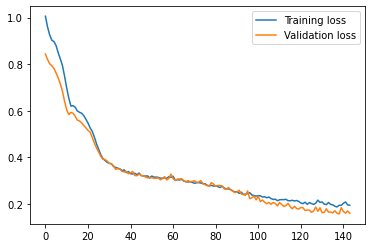

In [68]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [69]:
model.evaluate(X_test, y_test)


9/9 [==============================] - 1s 4ms/step - loss: 2.1761


2.176105499267578

Reconstruction error threshold: 0.5166803256520579


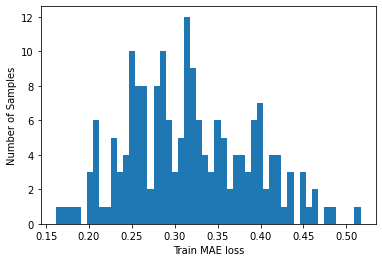

In [70]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

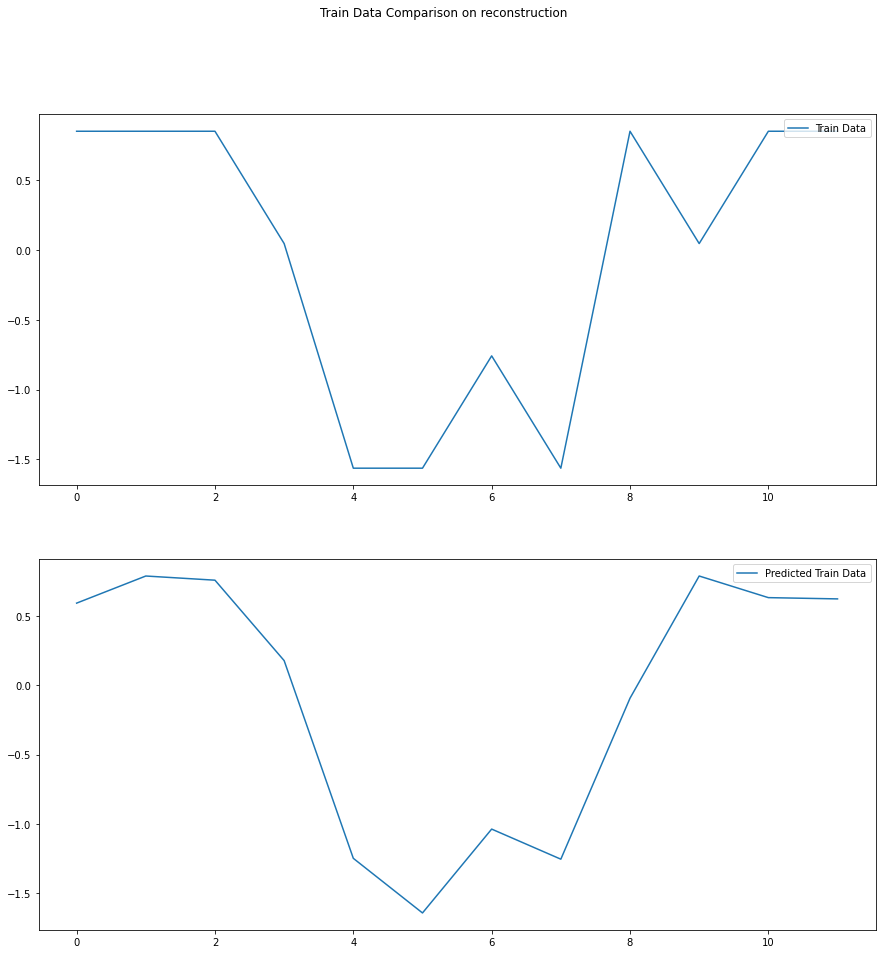

In [71]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(15,15))
fig.suptitle('Train Data Comparison on reconstruction')
ax1.plot(X_train[50],label='Train Data')
ax2.plot(X_train_pred[50],label='Predicted Train Data')
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
plt.show()


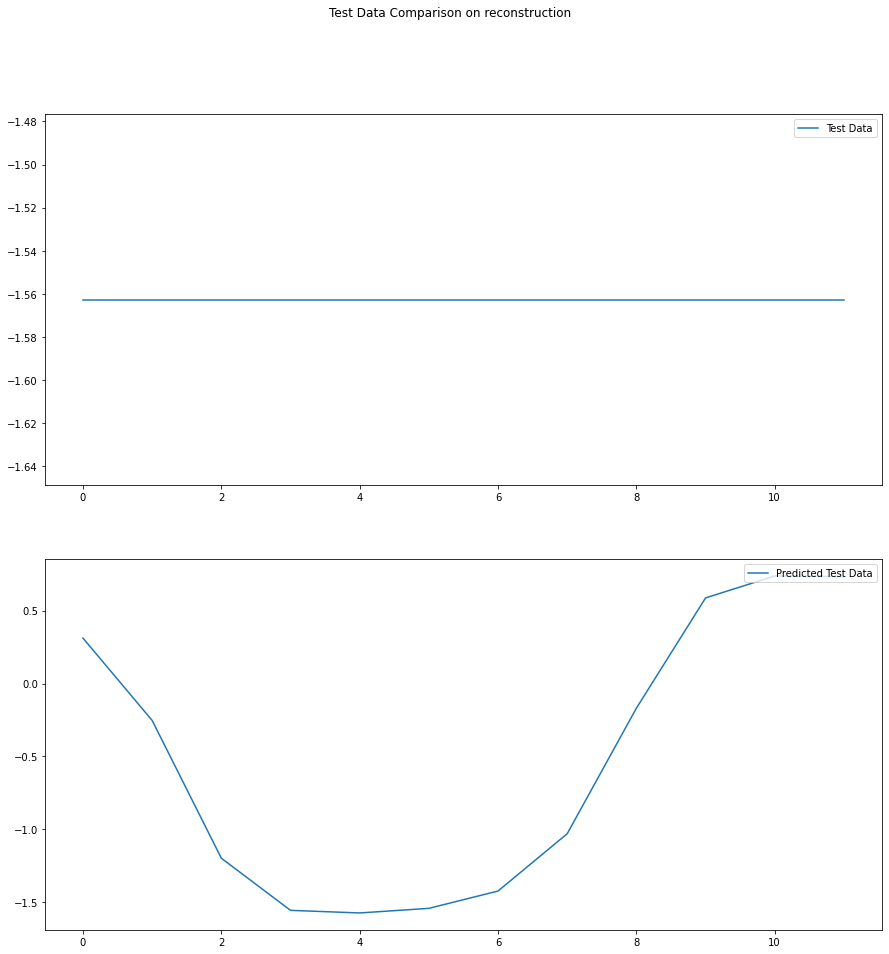

In [72]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(15,15))
fig.suptitle('Test Data Comparison on reconstruction')
ax1.plot(X_test[249],label='Test Data')
ax2.plot(X_test_pred[249],label='Predicted Test Data')
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
plt.show()

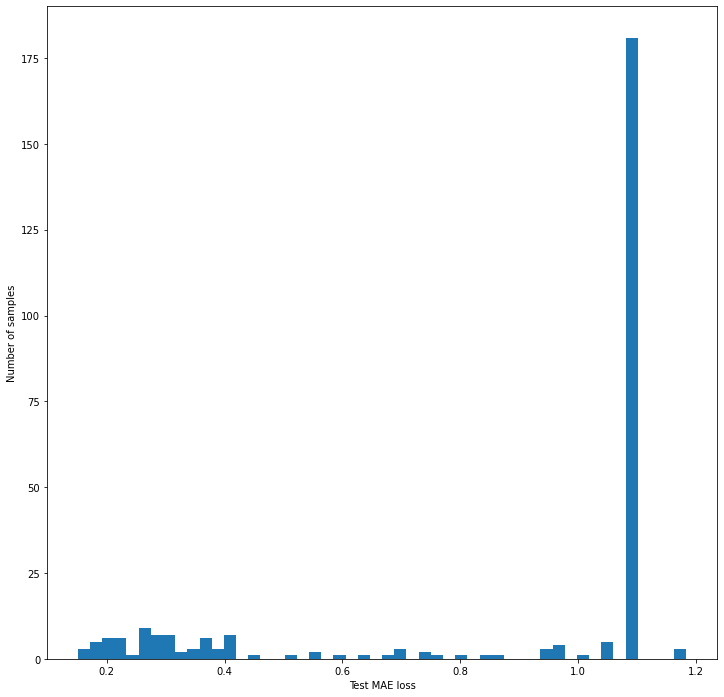

In [73]:

X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)
plt.figure(figsize=(12,12))
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [74]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = 1
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['WAFPUB'] = test[TIME_STEPS:]['WAFPUB']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test data Test loss vs. Threshold at 0.35')
fig.show()

In [45]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(194, 19)

In [63]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['WAFPUB'], name='WAFPUB '))
fig.update_layout(showlegend=True, title='Normal pattern on {}'.format(tool_name))
# fig.write_html("REX415_EU1_normal.html")
fig.show()

In [75]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df.index, y=scaler.inverse_transform(test_score_df['WAFPUB']), name='WAFPUB '))
fig.add_trace(go.Scatter(x=anomalies.index, y=scaler.inverse_transform(anomalies['WAFPUB']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies on {}'.format(tool_name))
# fig.write_html("REX415_EU1_anomalies.html")
fig.show()

# Sample code for simple visualization of periodic signal using Keras
Reference link : https://keras.io/examples/timeseries/timeseries_anomaly_detection/

In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [3]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [4]:
import keras; 
print(keras.__version__)


2.4.3


In [5]:
df_small_noise['value2'] = df_small_noise['value']

In [6]:
df_small_noise

,value,value2
timestamp,,
2014-04-01 00:00:00,18.324919,18.324919
2014-04-01 00:05:00,21.970327,21.970327
2014-04-01 00:10:00,18.624806,18.624806
2014-04-01 00:15:00,21.953684,21.953684
2014-04-01 00:20:00,21.909120,21.909120
...,...,...
2014-04-14 23:35:00,20.211195,20.211195
2014-04-14 23:40:00,20.531041,20.531041
2014-04-14 23:45:00,19.032127,19.032127


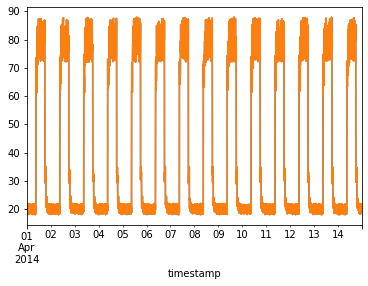

In [7]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

## Create multiple jump signal at randomize location ?

In [8]:
df_daily_jumpsup['value2'] = df_daily_jumpsup['value']

In [9]:
df_daily_jumpsup['value2'].iloc[288*3-1:288*4-1] = df_daily_jumpsup['value'].iloc[288*3-1:288*4-1]/2

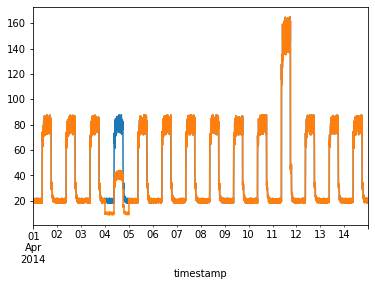

In [10]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [11]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [12]:
df_training_value.describe()

,value,value2
count,4.032000e+03,4.032000e+03
mean,-2.611667e-15,-2.611667e-15
std,1.000000e+00,1.000000e+00
min,-8.703666e-01,-8.703666e-01
25%,-8.048176e-01,-8.048176e-01
50%,-7.418804e-01,-7.418804e-01
75%,1.175759e+00,1.175759e+00
max,1.621882e+00,1.621882e+00


In [13]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 2)


In [14]:
print(x_train.shape[1]) # because of rolling window therefore will be 3744 timeframe (due to the last 288 will be included during the 3744th cycle)
print(x_train.shape[2])

288
2


Model building on Keras

In [191]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 144, 32)           480       
_________________________________________________________________
dropout_8 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_9 (Conv1DTr (None, 144, 16)           1808      
_________________________________________________________________
dropout_9 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_10 (Conv1DT (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_11 (Conv1DT (None, 288, 1)           

In [130]:
model = Sequential()
model.add(LSTM(128,input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(x_train.shape[1]))
model.add(LSTM(128,return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(x_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               67072     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 288, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 288, 128)          131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 288, 128)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 288, 2)            258       
Total params: 198,914
Trainable params: 198,914
Non-trainable params: 0
________________________________________________

In [38]:
# # define model
# model = Sequential()
# model.add(LSTM(128, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(x_train.shape[2])))
# model.compile(optimizer='adam', loss='mse')
# model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 288, 128)          66560     
_________________________________________________________________
lstm_15 (LSTM)               (None, 288, 64)           49408     
_________________________________________________________________
lstm_16 (LSTM)               (None, 288, 64)           33024     
_________________________________________________________________
lstm_17 (LSTM)               (None, 288, 128)          98816     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 288, 1)            129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
_________________________________________________________________


In [20]:
# model.fit(x_train, x_train, epochs=50, batch_size=127, verbose=1)
# # demonstrate reconstruction
# yhat = model.predict(X, verbose=1)
# print('---Predicted---')
# print(np.round(yhat,3))
# print('---Actual---')
# print(np.round(X, 3))

Train on 3744 samples
Epoch 1/50
2921/3744 [======================>.......] - ETA: 1:08 - loss: nan

KeyboardInterrupt: 

In [192]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 1s 30ms/step - loss: 0.6616 - val_loss: 0.0968
Epoch 2/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0884 - val_loss: 0.0416
Epoch 3/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0575 - val_loss: 0.0360
Epoch 4/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0474 - val_loss: 0.0321
Epoch 5/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0398 - val_loss: 0.0297
Epoch 6/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0350 - val_loss: 0.0277
Epoch 7/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0318 - val_loss: 0.0267
Epoch 8/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0292 - val_loss: 0.0283
Epoch 9/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0272 - val_loss: 0.0303
Epoch 10/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0254 - val_loss: 0.0313
Epoch 11/

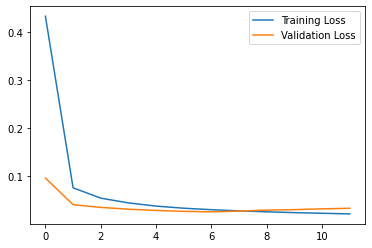

In [193]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

Detecting Anomalies

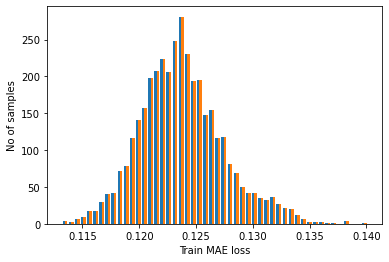

Reconstruction error threshold:  0.1400915256270276


In [194]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [195]:
x_train_pred.shape

(3744, 288, 1)

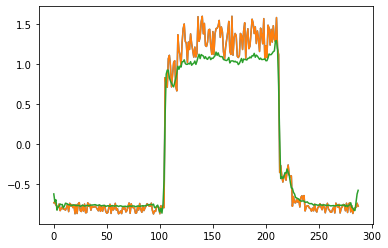

In [196]:
# Checking how the first sequence is learnt
plt.plot(x_train[3])
plt.plot(x_train_pred[3])
plt.show()

In [211]:
threshold

0.1400915256270276

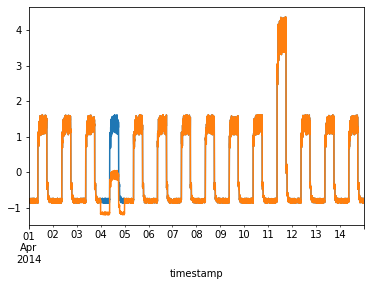

Test input shape:  (3744, 288, 2)


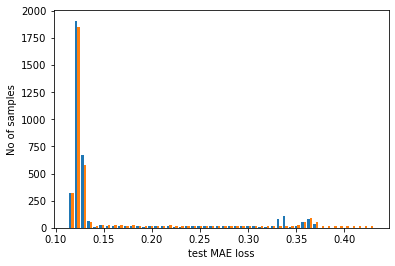

Number of anomaly samples:  1718
Indices of anomaly samples:  (array([ 592,  593,  594, ..., 3093, 3094, 3094], dtype=int64), array([1, 1, 1, ..., 1, 0, 1], dtype=int64))


In [241]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
# test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [242]:
x_test

array([[[-0.80767185, -0.80767185],
        [-0.78133079, -0.78133079],
        [-0.80053474, -0.80053474],
        ...,
        [-0.84984182, -0.84984182],
        [-0.84637559, -0.84637559],
        [-0.86378412, -0.86378412]],

       [[-0.78133079, -0.78133079],
        [-0.80053474, -0.80053474],
        [-0.74609097, -0.74609097],
        ...,
        [-0.84637559, -0.84637559],
        [-0.86378412, -0.86378412],
        [-0.74187577, -0.74187577]],

       [[-0.80053474, -0.80053474],
        [-0.74609097, -0.74609097],
        [-0.792482  , -0.792482  ],
        ...,
        [-0.86378412, -0.86378412],
        [-0.74187577, -0.74187577],
        [-0.79336052, -0.79336052]],

       ...,

       [[-0.75284306, -0.75284306],
        [-0.82278269, -0.82278269],
        [-0.80756241, -0.80756241],
        ...,
        [-0.82276841, -0.82276841],
        [-0.86774221, -0.86774221],
        [-0.76348065, -0.76348065]],

       [[-0.82278269, -0.82278269],
        [-0.80756241, -0.80

In [243]:
test_mae_loss_df = pd.DataFrame(test_mae_loss)

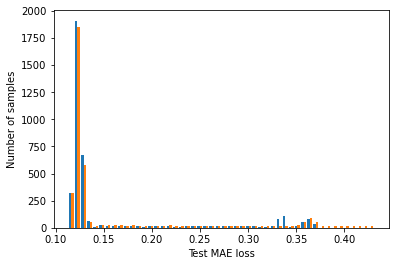

In [246]:

x_test_pred = model.predict(x_test, verbose=0)
test_mae_loss = np.mean(np.abs(x_test_pred-x_test), axis=1)

plt.hist(test_mae_loss_df, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [249]:
test_score_df = pd.DataFrame(df_test_value[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss_df.iloc[:,0].values
test_score_df['threshold'] = 0.3
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['IN_PROCESS'] = df_test_value[TIME_STEPS:]['value']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [251]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [252]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]


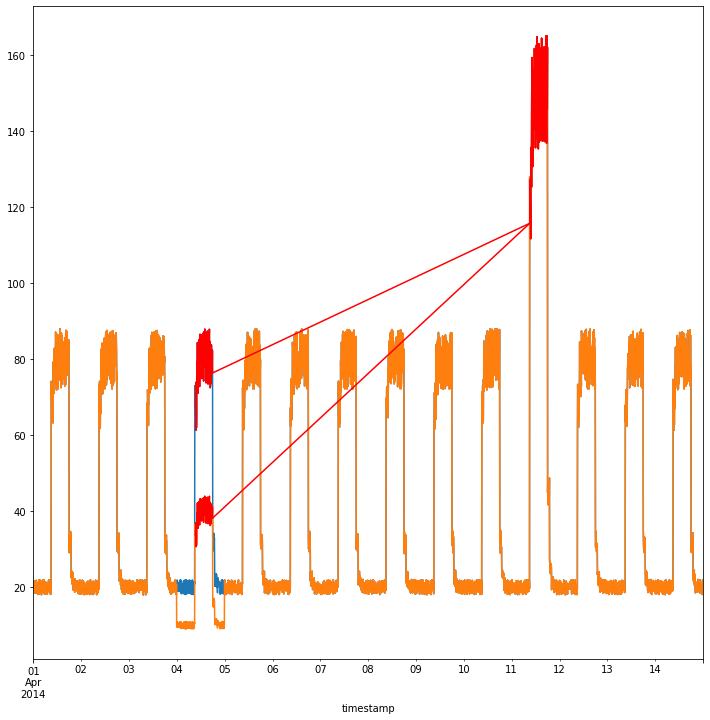

In [253]:
fig, ax = plt.subplots(figsize=(12,12))
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()